In [174]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def utility_function(risk_factor, portfolio_return):
    value = ((1 + portfolio_return)**(1-risk_factor))/(1-risk_factor)
    return value

## Optimization formula:
## $\underset{\theta}{\max} \frac{1}{T} \sum^{T-1}_{t=0} u\left( \sum_{i=1}^{N_{t}}( \bar{w}_{i,t} + \frac{1}{N_{t}}\theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} \right) $

## Critical point of formula:

## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $


## Utility function

## $u(r_{p,t+1}) = \frac{(1+r_{p,t+1})^{1-\gamma}}{1-\gamma} $

## Portfolio return
## $ r_{p,t+1} = \sum^{N_{t}}_{i=1} \bar{w}_{i,t} r_{i,t+1} + \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \theta^{\text{T}} \hat{x}_{i,t} ) r_{i,t+1} $


## Utility function derivate

## $u'(r_{p,t+1}) = (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} $

## Portfolio return derivate
## $ r'_{p,t+1} = \sum^{N_{t}}_{i=1} (  \frac{1}{N_{t}} \hat{x}_{i,t} ) r_{i,t+1} = \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} $

## Critical point expanded:
## $ \frac{1}{T} \sum^{T-1}_{t=0} u'(r_{p,t+1}) \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} r'_{p, t+1} \frac{1}{N_{t}}\hat{x}_{t}^{\text{T}} r_{t+1} = 0 $
## $ \frac{1}{T} \sum^{T-1}_{t=0} (1+r_{p, t+1})^{-\gamma} (r'_{p, t+1})^2 $

In [81]:
from collections import defaultdict

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = dict()
# random initialization of theta for 3 firm characteristics
theta = np.random.rand(1, 3)
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3

return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    firm_characteristics[i] = defaultdict(list)
    for t in range(time):
        # Toy firm characteristics 
        me = np.random.uniform(-1,1)
        btm = np.random.uniform(-1,1)
        mom = np.random.uniform(-1,1)
        firm_characteristics[i]['me'].append(me)
        firm_characteristics[i]['btm'].append(btm)
        firm_characteristics[i]['mom'].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

        
for k in range(100):
    gradient=0
    for t in range(time):
        r_p_grad = 0
        r_p = 0
        # calculate gradient
        for i in range(number_of_stocks):
            firm_df = pd.DataFrame(firm_characteristics[i])
            r_p_grad += (1/number_of_stocks)*firm_df.iloc[t] * r[i][t]
            r_p += (1/number_of_stocks)*theta.dot(firm_df.iloc[t])*r[i][t]
        u_grad = pow((1+r_p),-gamma) *  r_p_grad
        print(f"Sum \n{gradient}")
        gradient+= u_grad * r_p_grad

        # gradient ascendent for each theta at time t
    theta += lr * gradient
    print(f" Theta :{theta}, k:{k}")
    # Avaliate function
    utility_values = []
    for t in range(time-1):
        r_p = 0
        for i in range(number_of_stocks):
            firm_df = pd.DataFrame(firm_characteristics[i])
            w[i][t] = (1/number_of_stocks)*theta.dot(firm_df.iloc[t])
            
            r_p += w[i][t] * r[i][t+1]
        utility_values.append(utility_function(5, r_p))
    
    return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(return_portifolio)
    print(f"Return {return_portifolio}")
    break

Sum 
0
Sum 
me     0.012651
btm    0.516860
mom    0.004360
Name: 0, dtype: float64
Sum 
me     0.012678
btm    0.696910
mom    0.094378
Name: 0, dtype: float64
Sum 
me     0.014921
btm    1.062556
mom    0.119041
Name: 0, dtype: float64
Sum 
me     0.017017
btm    1.247094
mom    0.133568
Name: 0, dtype: float64
Sum 
me     0.244645
btm    2.267973
mom    0.336710
Name: 0, dtype: float64
Sum 
me     0.270208
btm    3.051084
mom    0.341318
Name: 0, dtype: float64
Sum 
me     0.488861
btm    3.845195
mom    0.410493
Name: 0, dtype: float64
Sum 
me     0.488943
btm    4.014828
mom    0.474035
Name: 0, dtype: float64
Sum 
me     24.607917
btm    35.916476
mom     0.604109
Name: 0, dtype: float64
Sum 
me     24.628901
btm    36.140637
mom     0.618872
Name: 0, dtype: float64
Sum 
me     24.638261
btm    36.495793
mom     0.646951
Name: 0, dtype: float64
Sum 
me     24.670991
btm    36.917885
mom     0.887131
Name: 0, dtype: float64
Sum 
me     24.686809
btm    36.946464
mom     0.921017
N

In [9]:
r[i]

array([ 1.40497587,  1.97652092,  3.68554188, -2.19013986,  2.59254675,
        1.40029697,  0.83865737, -0.99848102,  2.47033647, -0.80498666,
       -3.29487066,  1.75478112,  2.03526411, -2.34445533,  1.46110032,
       -2.37978828, -1.01537646,  1.42382927, -0.90947055, -0.1109635 ,
       -0.64535839, -0.94665652, -2.353038  ,  3.2724097 ,  1.51756462,
       -4.94569651,  0.28442536, -4.25592262,  2.06655618, -2.02319025,
        1.50330435,  3.11703216,  2.77999798, -1.51437409, -2.21580198,
        0.8551267 , -0.65882471,  1.16284494, -1.50330158,  2.53925178,
        3.35296832, -1.44103799,  2.17991138, -2.69959239,  1.91295362,
       -0.14290421, -0.18742639, -4.00250036,  2.87592373, -2.40805596,
        1.46635449, -2.69759503, -0.48576713, -3.32722211,  1.3691237 ,
       -3.73101481, -0.60635199, -0.25688916, -1.52934727,  2.4038514 ,
        1.71884479, -0.51079685,  0.90342658,  0.24129946,  2.83859669,
        0.3940193 , -3.68250165, -0.62276672, -2.44313712, -1.47

In [6]:
firms_coeff = theta.dot(firm_df.T)
normalized_firms = (firms_coeff - firms_coeff.mean())

In [9]:
normalized_firms.std()

0.4548705081338074

In [14]:
r_p_grad = 0
r_p = 0



# calculate gradient
for i in range(number_of_stocks):
    firm_df = pd.DataFrame(firm_characteristics[i])
    firms_coeff = theta.dot(firm_df.T)
    # Normalize coefficents with firm characteristics to have 0 mean
    normalized_firms = (firms_coeff - firms_coeff.mean())/firms_coeff.std()
    r_p_grad += firm_df.T.dot(r[i])
    r_p += normalized_firms.dot(r[i])
r_p *= (1/number_of_stocks)
r_p_grad *= (1/number_of_stocks)
u_grad = pow((1+r_p),-gamma) *  r_p_grad
gradient = u_grad * r_p_grad
theta += lr * gradient
# print(f" Theta :{theta}, k:{k}")

# # Avaliate function
# utility_values = []
# for t in range(time-1):
#     r_p = 0
#     for i in range(number_of_stocks):
#         firm_df = pd.DataFrame(firm_characteristics[i])
#         w[i][t] = (1/number_of_stocks)*theta.dot(firm_df.iloc[t])

#         r_p += w[i][t] * r[i][t+1]
#     utility_values.append(utility_function(5, r_p))

# return_portifolio = sum(utility_values)/len(utility_values)
# return_all.append(return_portifolio)
# print(f"Return {return_portifolio}")
# break

In [66]:
np.power((1+r_p),-gamma)

array([1.13552426e-08, 1.13544444e-08, 1.13167240e-08, 1.13234030e-08,
       1.13241629e-08, 1.14768239e-08, 1.13953924e-08, 1.15920793e-08,
       1.17826362e-08, 1.14999372e-08])

In [69]:
r_p_grad**2

me       322.347855
btm    10914.198918
mom     2361.456283
dtype: float64

In [187]:
r_p_grad=0
r_p = 0

time = 90 # 90 days
number_of_stocks = 10
np.random.seed(123)
r = np.empty(shape=(number_of_stocks,time))
gamma = 5
firm_characteristics = dict()
# random initialization of theta for 3 firm characteristics
theta = np.random.rand(1, 3)
w = np.empty(shape=(number_of_stocks, time))
# Learning rate
lr = 1e-3

return_all = []

# Creating artificial return
for i in range(number_of_stocks):
    firm_characteristics[i] = defaultdict(list)
    for t in range(time):
        # Toy firm characteristics 
        me = np.random.uniform(-1,1)
        btm = np.random.uniform(-1,1)
        mom = np.random.uniform(-1,1)
        firm_characteristics[i]['me'].append(me)
        firm_characteristics[i]['btm'].append(btm)
        firm_characteristics[i]['mom'].append(mom)
        # simplified weight using only firm characteristics
        # return of portifolio i at time t
        r[i][t] = (-0.337*me + 3.553*btm + 1.623*mom)

print("Created all artificial stocks")

for k in tqdm(range(100)):
    for i in range(number_of_stocks):
        firm_df = pd.DataFrame(firm_characteristics[i])
        firms_coeff = theta.dot(firm_df.T)
        normalized_firms = (firms_coeff - firms_coeff.mean())
        r_p_grad += firm_df.T.dot(r[i])
        r_p += normalized_firms.dot(r[i])
    r_p *= (1/number_of_stocks)
    r_p_grad *= (1/number_of_stocks)
    u_grad_all = np.power((1+r_p),-gamma)
    gradient = u_grad*r_p_grad**2 
    # sum all over t to create gradient ?
    theta += lr * gradient

#     print(f" Theta :{theta}, k:{k}")
    w = np.empty(shape=(number_of_stocks, time))
    # Avaliate function
    for i in range(number_of_stocks):
        firm_df = pd.DataFrame(firm_characteristics[i])
        firms_coeff = theta.dot(firm_df.T)
        normalized_firms = (firms_coeff - firms_coeff.mean())
        w[i] = (1/number_of_stocks)*normalized_firms

    r_p = np.array([sum(w[:,t]*r[:,t+1]) for t in range(time-1)])
    utility_values = utility_function(5, r_p)
    return_portifolio = sum(utility_values)/len(utility_values)
    return_all.append(return_portifolio)
#     print(f"Return {return_portifolio}")

Created all artificial stocks


In [188]:
w[:,0]

array([ 12.27969701,  -0.9173161 ,  -6.53015131, -21.11084403,
         4.1281934 ,  25.20864884,  -7.951403  ,  22.79426127,
       -22.06095322,  17.39962849])

In [189]:
pd.DataFrame(return_all).describe()

,0
count,1.000000e+02
mean,-3.383085e+09
std,3.367663e+10
min,-3.367784e+11
25%,-5.810868e+01
50%,-1.838172e+00
75%,-2.090188e-01
max,-4.220857e-02


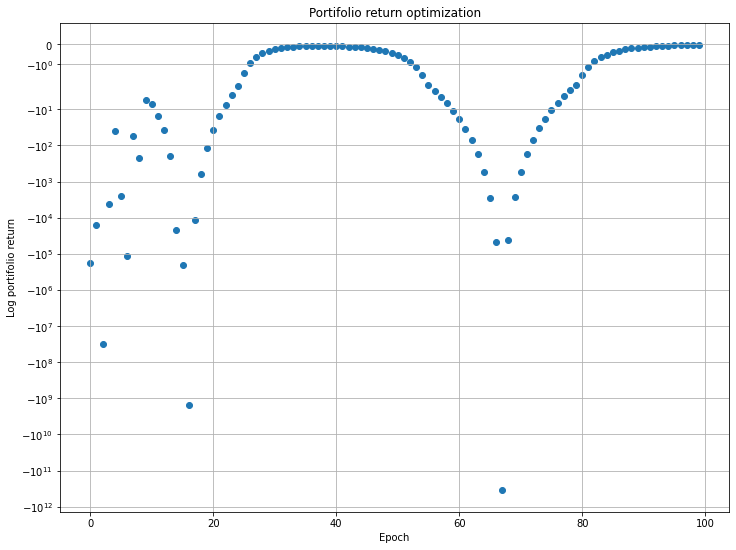

In [190]:
plt.figure(figsize=(12,9))
plt.yscale('symlog')
plt.scatter(x=range(len(return_all)), y=return_all)
plt.title('Portifolio return optimization')
plt.ylabel('Log portifolio return')
plt.xlabel('Epoch')
plt.grid()
plt.show()

In [191]:
return_all[-2]

-0.047903628798085594

In [ ]:


# benchmark portifolio weight of stock i on time t
w_i_t_bench = 1.0

# weight of stock i on time t
w_i_t = w_i_t_bench + (1/number_of_stocks)*X.dot(firm_characteristics)

# Where X is a vector of coefficients that we want to find and firm_characteristics are a vector of firm characteristics.
